<a href="https://colab.research.google.com/github/HiroForYou/A-Hackers-AI-Voice-Assistant/blob/master/Aprendizaje_Reforzado_World_Models_y_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Práctica calificada 4

* En esta tarea se evaluará todas las preguntas y no se asignará puntaje a preguntas incompletas.
* Todo acto de COPIA implica la nota de 0A. Evita copiar!.

1. Se pueden realizar implementaciones de algoritmos de RL desde cero o haciendo uso de implementaciones de librerías y paquetes de Python, como el paquete RLlib que es parte de la librería Ray. Explica de manera suscinta y precisa que hacen los siguientes algoritmos y escoge dos de ellos y realiza su implementación (debes indicar por ejemplo cuáles son de modelos basados en RL, Q-learning, etc en tus explicaciones).

    a. PPO (Proximal Policy Optimization)

    b. DDPG (Deep Deterministic Policy Gradient)

    c. TD3 (Twin Delayed DDPG)

    d. C51 (Categorical 51-Atom DQN)

    e. World Models

    f. MBVE (Model-Based Value Expansion)

    g. AlphaZero

## **IMPLEMENTACIÓN DE WORLD MODELS**

Uno de los temas principales de **Reinforcement Learning** es la complejidad de la muestra. Por lo tanto, es atractivo entrenar agentes RL en un simulador que elimina la necesidad de recoger muestras de un agente que interactúa con el mundo. World Models es un ejemplo convincente de este enfoque. La idea básica es entrenar primero un modelo que entienda el mundo y luego utilizar las características aprendidas por el modelo para entrenar a un agente o entrenar a un agente completamente dentro del modelo.

<p align="center">
  <img src="https://miro.medium.com/max/730/1*QkJJSXv3o6oVx37BMzuqyg.png" />
  <p align="center">"Entender el mundo a partir de los sueños"</p>
</p>



## **Arquitectura**

Hay tres componentes principales propuestos en los modelos mundiales:

1.   El encoder o módulo de visión (V)
2.   El modelo (M)
3.   El controlador (C)

*   **Encoder (V)**


El encoder es un *variational autoencoder* básico que asigna imágenes desde un espacio de 64x64x3 (3 desde canales RGB) hasta un vector latente (z) de dimensión igual a 64.

<p align="center">
  <img src="https://miro.medium.com/max/875/1*fJcdC8VRmWiKLNhh1IToWA.png" />
  <p align="center">Arquitectura del autoencoder</p>
</p>

El objetivo general de un *variational autoencoder* es encontrar una representación dimensional mínima (z) de la observación. Esto se hace minimizando la pérdida de reconstrucción (primer término) con una penalización (segundo término) por moverse lejos de las creencias (**P(z)**).

<p align="center">
  <img src="https://miro.medium.com/max/875/1*rNL3ZlUXiIIQQH4fkNeKwQ.png" />
  <p align="center">Ecuación a minimizar</p>
</p>


El encoder está representado por **q(z|x)** y el decoder está representado por **p(x|z**). Donde **x** es la observación en bruto.


*  **Modelo(M)**

El modelo es una red neuronal recurrente **Mixture Density** (MD-RNN). La MD-RNN toma **z** (definido anteriormente) como entrada y predice **π**, **μ** y **σ** a través de pasos de tiempo futuros. **π** es un vector *k-dimensional* que representa los logits de una distribución multinomial. Hay *k* diferentes **μ** y **σ** que se utilizarán para parametrizar *k* distribuciones gaussianas multidimensionales separadas.

<p align="center">
  <img src="https://miro.medium.com/max/550/1*HDcyrnNO83CJQOohhvNZCQ.png" />
  <p align="center">La red tomo como entrada el vector z</p>
</p>

Para extraer una muestra de la red MD-RNN, primero tomamos muestras del parámetro multinomial parametrizado por **π** y luego la muestra se utilizaría para identificar de cuál de las distribuciones normales multidimensionales *k* vamos a muestrear.

La red neuronal recurrente produce un vector de estado oculto **(h)** y un vector **(c)** de estado de celda que será útil más adelante.

*  **Controlador (C)**

El controlador **(C)** es responsable de decidir qué acciones tomar, en qué parte de los experimentos las acciones toman valores contínuos (sin embargo, esto podría generalizarse fácilmente en el caso discreto). Los autores hacen que **C** sea lo más simple posible para demostrar que la mayor parte de la complejidad se encuentra dentro del encoder **(v)** y el modelo **(m)**. El controlador simple es un modelo lineal de una sola capa que utiliza un algoritmo evolutivo para encontrar sus parámetros **[(CMA-ES)](https://arxiv.org/pdf/1604.00772.pdf)**.
Observe que el controlador es un modelo lineal con respecto a sus entradas y **NO** la observación en bruto. 

Dependiendo del entorno, la entrada es una concatenación de **[observación codificada (z), vector de estado oculto (h)]** o **[una observación codificada(z), estado oculto (h), estado de celda (c)]**.


*  **Entrenamiento**

El esquema de entrenamiento sigue un proceso de 4 pasos después de inicializar **V**, **M** y **C**: 

1.   Recoge las trayectorias del controlador (**C**) 
2.   Utiliza las observaciones en bruto para entrenar **V**
3.   Codifica las observaciones en bruto al espacio latente **z** con **V**, luego entrena **M** 
4.   Utiliza **z**, **h** y **c** (a veces) para entrenar el controlador (**C**)


Al entrenar al controlador tenemos la opción de entrenar en el entorno real o inicializar **M** con un valor aleatorio y entrenar al controlador dentro de sus propios **"sueños"**. Los autores especulan que el entrenamiento dentro de entornos sintéticos no era factible en **simuladores de entorno recurrentes** o **predicciones de vídeo condicionado a alguna acción** porque el controlador fue capaz de aprovechar las imperfecciones en el modelo (**M**). Sin embargo, en este caso se introduce un parámetro de temperatura (**τ**) en la distribución multinomial que crea más aleatoriedad en las muestras del modelo (**M**). Esto es interesante porque aunque empeora el modelo, obliga al controlador a ser más robusto.

La segunda opción es convincente porque facilitaría el entrenamiento de un agente en entornos **"peligrosos"**. Por peligroso nos referimos a entornos donde interactuar con él puede tener consecuencias catastróficas. Por ejemplo, imagine liberar un controlador inicializado aleatoriamente en la carretera abierta.

Una nota final a tener en cuenta es cuando el entorno no se *explora* lo suficiente con un controlador aleatorio, esto significaría que su modelo nunca aprendería acerca de la dinámica que solo experimentará un controlador fuerte. Para navegar por este problema, los autores sugieren realizar iterativamente los 4 pasos mencionados anteriormente. Sin embargo, esto no se demostró en ninguno de los experimentos.

A continuación se muestra la implementación del modelo en Pytorch usando el entorno GYM.

In [1]:
!git clone https://github.com/HiroForYou/RL-Algorithms.git  # descargarmos el repositorio base
%cd RL-Algorithms/World-Models-PyTorch/ 
!ls

Cloning into 'RL-Algorithms'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 31 (delta 2), reused 31 (delta 2), pack-reused 0
Unpacking objects: 100% (31/31), done.
/content/RL-Algorithms/World-Models-PyTorch
car_racing.py		 pushover.py	 sample_image.png  vae.ipynb
generate-rollouts.ipynb  real_image.png  utils.py	   vae.py
generate-rollouts.py	 rollouts	 vae-cnn.ipynb


In [2]:
# para correr las gráficas sin problemas necesitamos una versión de Pyglet compatible con GYM
!pip uninstall pyglet     
!pip install pyglet==1.3.2

Uninstalling pyglet-1.5.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pyglet-1.5.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pyglet/*
Proceed (y/n)? y
  Successfully uninstalled pyglet-1.5.0
     |████████████████████████████████| 1.0MB 5.2MB/s 
ERROR: gym 0.17.3 has requirement pyglet<=1.5.0,>=1.4.0, but you'll have pyglet 1.3.2 which is incompatible.


In [3]:
# instalamos otras dependencias para poder mostrar los gráficos GYM en Colab
!pip install Box2D
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

     |████████████████████████████████| 1.3MB 4.2MB/s 


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

# from pushover import notify # en caso deseemos notificar por celular
from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

In [5]:
# configuramos el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
# creamos una pantalla falsa en COLAB para mostrar la interfaz GYM
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [7]:
# generamos la imágenes que serán colocadas dentro de la carpeta creada arriba.
# las imágenes van acompañas de la recompensa actual (mayor recompensa si el 
# coche se encuentra dentro de la línea)
!pip install pyglet==1.3.2
!python generate-rollouts.py

  Using cached https://files.pythonhosted.org/packages/1c/fc/dad5eaaab68f0c21e2f906a94ddb98175662cc5a654eee404d59554ce0fa/pyglet-1.3.2-py2.py3-none-any.whl
ERROR: gym 0.17.3 has requirement pyglet<=1.5.0,>=1.4.0, but you'll have pyglet 1.3.2 which is incompatible.
  Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Episode [1/100]: CummReward 6.13
Episode [2/100]: CummReward 37.82
Episode [3/100]: CummReward 3.07
Episode [4/100]: CummReward 35.36
Episode [5/100]: CummReward 15.72
Episode [6/100]: CummReward 12.95
Episode [7/100]: CummReward 9.39
Episode [8/100]: CummReward 11.06
Episode [9/100]: CummReward 9.69
Episode [10/100]: CummReward 6.54
Episode [11/100]: CummReward 6.08
Episode [12/100]: CummReward 3.35
Episode [13/100]: C

In [8]:
bs = 32 # tamaño del batch 

# Cargamos los datos recién creados
dataset = datasets.ImageFolder(root='./rollouts', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)

(3000, 94)

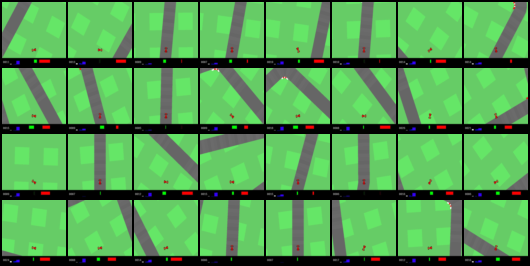

In [9]:
# fijamos la entrada para su análisis
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [10]:
# esta clase será útil para aplanar un tensor a forma unidimensional
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [11]:
# esta clase será útil para restaurar un tensor unidimensional a su forma 
# original
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [12]:
# creamos el autoencoder como se definió en la parte teórica
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [13]:
image_channels = fixed_x.size(1)


In [14]:
# instanciamos el autoencoder

#vae = VAE(image_channels=image_channels).to(device)
vae = VAE(image_channels=image_channels).to(device)
#vae.load_state_dict(torch.load('vae.torch', map_location='cpu'))   # en caso ya tenga los pesos creados

In [15]:
# en este caso usamos el optimizador ADAM para poder encontrar los parámetros 
# óptimo de la función de coste principal definida en la parte teórica

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [16]:
# implementamos de la función de coste detallada en la parte teórica
def loss_fn(recon_x, x, mu, logvar):

    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [17]:
# en esta carpeta almacenaremos las imágenes reconstruidas del escenario,
# a partir de los 'sueños' del agente

!rm -rfr reconstructed
!mkdir reconstructed

In [18]:
# ejecutamos el entrenamiento solo para 5 épocas porque toma tiempo
epochs = 5

for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoca[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.item()/bs, bce.item()/bs, kld.item()/bs)
        print(to_print)

# notificamos por android la finalización del entrenamiento
# notify(to_print, priority=1)


# guardamos el modelo para poder hacer la inferencia
torch.save(vae.state_dict(), 'vae.torch')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoca[1/5] Loss: 8474.553 8474.553 0.000
Epoca[1/5] Loss: 8444.570 8444.570 0.000
Epoca[1/5] Loss: 8353.003 8353.002 0.001
Epoca[1/5] Loss: 8320.265 8320.251 0.014
Epoca[1/5] Loss: 8187.921 8187.919 0.003
Epoca[1/5] Loss: 8182.948 8182.947 0.001
Epoca[1/5] Loss: 8106.377 8106.377 0.001
Epoca[1/5] Loss: 8037.938 8037.937 0.001
Epoca[1/5] Loss: 8090.505 8090.505 0.001
Epoca[1/5] Loss: 8004.879 8004.878 0.001
Epoca[1/5] Loss: 8021.161 8021.161 0.000
Epoca[1/5] Loss: 7975.412 7975.412 0.000
Epoca[1/5] Loss: 7967.077 7967.077 0.001
Epoca[1/5] Loss: 7910.482 7910.481 0.001
Epoca[1/5] Loss: 7884.644 7884.642 0.002
Epoca[1/5] Loss: 7856.095 7856.091 0.003
Epoca[1/5] Loss: 7885.331 7885.326 0.005
Epoca[1/5] Loss: 7823.820 7823.816 0.004
Epoca[1/5] Loss: 7773.064 7773.060 0.004
Epoca[1/5] Loss: 7731.350 7731.343 0.007
Epoca[1/5] Loss: 7635.578 7635.565 0.013
Epoca[1/5] Loss: 7624.021 7624.001 0.020
Epoca[1/5] Loss: 7541.068 7541.052 0.016
Epoca[1/5] Loss: 7491.818 7491.804 0.015
Epoca[1/5] Loss:

In [19]:
# esta función concatena la imagen verdadera con la imagen
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

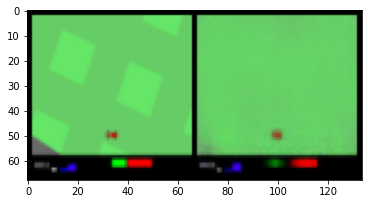

In [20]:
# ejecutamos esta celda las veces que queramos; se mostrará una imagen diferente

# sample = torch.randn(bs, 1024)
# compare_x = vae.decoder(sample)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'imagen_ejemplo.png')

plt.imshow(plt.imread('imagen_ejemplo.png'))

## **IMPLEMENTACIÓN PPO**

### **Detalles sobre el funcionamiento de los entornos**

Una configuración típica de Aprendizaje de Refuerzo funciona haciendo que un agente de IA interactúe con nuestro entorno. El agente observa el **estado** actual de nuestro entorno, y en base a alguna **política** toma una decisión de hacer una **acción** en particular. Esta acción se transmite de nuevo al entorno que avanza un **paso**. Esto genera una **recompensa** que indica si la acción tomada fue positiva o negativa en el contexto del juego que se está jugando. Usando esta recompensa como retroalimentación, el agente intenta averiguar cómo modificar su política existente con el fin de obtener mejores recompensas en el futuro.

### **Detalles sobre el entorno LunarLander-v3 (entorno discreto)**
La plataforma de aterrizaje siempre está en coordenadas (0,0). Las coordenadas son los dos primeros números en el vector de estado. Recompensa por pasar de la parte superior de la pantalla a la plataforma de aterrizaje y la velocidad cero es de aproximadamente 100..140 puntos. Si el **lander** se aleja de la plataforma de aterrizaje pierde la recompensa hacia atrás. Episodio termina si el lander se estrella o llega a descansar, recibiendo -100 o +100 puntos adicionales. Cada contacto con el suelo de la pierna es +10. El uso del motor principal da una recompensa de -0,3 puntos por cada frame. El máximo puntaje es de 200 puntos. Aterrizar fuera de la plataforma de aterrizaje es posible. El combustible es infinito, por lo que un agente puede aprender a volar y luego aterrizar en su primer intento. 

Hay cuatro acciones discretas disponibles: no hacer nada, motor de orientación izquierda, motor principal, motor de orientación derecha.

<p align="center">
  <img src="https://miro.medium.com/max/1250/1*6glcLVg9gwGEJzs-iU4YPA.png" />
  <p align="center">Entrono de ejecución</p>
</p>


### **Algoritmo PPO**

El algoritmo [Proximal Policy Optimization (PPO)](https://arxiv.org/abs/1707.06347) fue introducido por el equipo de OpenAI en 2017 y rápidamente se convirtió en uno de los métodos de aprendizaje de refuerzo más populares que empujaron todos los demás métodos de RL en ese momento a un lado. PPO implica recopilar un pequeño lote de experiencias que interactúan con el entorno y utilizan ese lote para actualizar su política de toma de decisiones. 

Una vez que la política se actualiza con ese lote, las experiencias se desechan y se recopila un lote más reciente con la política recién actualizada. Esta es la razón por la que es un enfoque de **"aprendizaje en política"** donde las muestras de experiencia recopiladas solo son útiles para actualizar la política actual.

La idea principal es que después de una actualización, la nueva política no debe estar demasiado lejos de la política anterior. Para eso, PPO utiliza el recorte o **'clip'** para evitar actualizaciones demasiado grandes. Esto conduce a una menor varianza en el entrenamiento a costa de cierto sesgo, pero asegura un entrenamiento más suave y también se asegura de que el agente no vaya a un camino irrecuperable de tomar acciones sin sentido. Por lo tanto, vamos a seguir adelante y desglosar nuestro agente en más detalles y ver cómo define y actualiza su política.



* ## **La estructura del modelo Actor-Critic**


PPO utiliza el enfoque Actor-Critic para el agente. Esto significa, que utiliza dos modelos, uno llamado el Actor y el otro llamado Crítico:

<p align="center">
  <img src="https://miro.medium.com/max/1250/1*1P6BVgsADf3uX7xaLt3rqA.png" />
  <p align="center">Estructura del modelo Actor-Critic</p>
</p>


1. **El modelo actor**

Realiza la tarea de aprender qué acción tomar bajo un estado observado particular del entorno. En el caso LunarLander-v3, toma 8 valores de lista del juego como entrada que representa el estado actual de nuestro cohete y da una acción particular sobre qué motor disparar como salida:

<p align="center">
  <img src="https://miro.medium.com/max/1250/1*0SaYUGGEiZO0iv0FCeABjw.png" />
  <p align="center">Modelo actor</p>
</p>


*   *Pérdida de PPO personalizada*


Esta es la parte más importante del algoritmo PPO.
Las probabilidades nuevas y las probabilidades antiguas de las acciones indican la política definida por nuestro modelo de red neuronal **actor**. Al entrenar este modelo, queremos mejorar estas probabilidades para que nos dé mejores y mejores acciones con el tiempo. Ahora un problema importante en algunos enfoques de aprendizaje de refuerzo es que una vez que nuestro modelo adopta una mala política, sólo toma malas acciones en el juego, por lo que no podemos generar ninguna buena acción a partir de ahí en conducirnos por un camino irrecuperable en el entrenamiento. PPO intenta abordar esto solo realizando pequeñas actualizaciones del modelo en un paso de actualización, estabilizando así el proceso de entrenamiento.

2. **El modelo crítico**

Enviamos la acción predicha por el **actor** a nuestro entorno y observamos lo que sucede en el juego. Si algo positivo sucede como resultado de nuestra acción, como aterrizar una nave espacial, entonces el entorno devuelve una respuesta positiva en forma de recompensa. Pero si nuestra nave espacial cae, recibimos una recompensa negativa. Estas recompensas se aceptan entrenando la red:

<p align="center">
  <img src="https://miro.medium.com/max/1250/1*5CdBMVwuVctrIzQ1aE9xbg.png" />
  <p align="center">Modelo crítico</p>
</p>

El papel principal del modelo crítico es aprender a evaluar si la acción tomada por el actor llevó a nuestro entorno a estar en un mejor estado o no y dar su opinión al actor. El crítico genera un número real que indica una calificación (valor Q) de la acción realizada en el estado anterior. Al comparar esta calificación obtenida del crítico, el actor puede comparar su política actual con una nueva política y decidir cómo quiere mejorarse a sí mismo para tomar mejores acciones.

Ahora, un paso importante en el algoritmo PPO es ejecutar a través de todo este loop con los dos modelos para un número fijo de pasos conocidos como **pasos PPO**. Así que esencialmente, estamos interactuando con nuestro entorno para un cierto número de pasos y recolectando los estados, acciones, recompensas, etc. que usaremos para el entrenamiento.

A continuación se presenta una implementación del algoritmo PPO escrito en Pytorch, en este caso para el entorno de aterrizaje de la nave.

In [21]:
%cd ..
%cd PPO-PyTorch

/content/RL-Algorithms
/content/RL-Algorithms/PPO-PyTorch


In [22]:
# instalamos algunas dependencias para poder levantar la interfaz GYM
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install box2d-py

     |████████████████████████████████| 450kB 5.3MB/s 


In [23]:
import gym
from PIL import Image

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [24]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


In [25]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )
        
        # critico
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, 1)
                )
        
    def forward(self):
        raise NotImplementedError
        
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device) 
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy
        

In [26]:
class PPO:
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory):   
        # Estimación de Monte Carlo de las recompensas de estado
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizamos las recompensas
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convertimos la lista a tipo tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimizamos la política para k épocas
        for _ in range(self.K_epochs):
            # Evaluamos los valores y acciones antiguas:
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # encontramos la relación (pi_theta / pi_theta__antiguo):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # actualizamos los parámetros
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # copìamos los nuevos pesos dentro de la antigua política:
        self.policy_old.load_state_dict(self.policy.state_dict())
        

In [27]:
%matplotlib inline
%pylab inline


display = Display(visible=0, size=(400, 300))
display.start()

def test():
    ############## Hiperparámetros ##############
    env_name = f"LunarLander-v2"
    # creamos nuestro entorno
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = 4
    render = False
    max_timesteps = 500
    n_latent_var = 64           # número de variables en la capa oculta
    lr = 0.0007
    betas = (0.9, 0.999)
    gamma = 0.99                # factor de descuento
    K_epochs = 4                # actualizamos la política cada k épocas
    eps_clip = 0.2              # cortamos o clipeamos los parámetros de acuerdo a PPO
    #############################################

    n_episodes = 3
    max_timesteps = 300
    render = True
    save_gif = False

    filename = "PPO_{}.pth".format(env_name)
    directory = "./preTrained/"
    
    memory = Memory()
    ppo = PPO(state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip)
    ppo.policy_old.load_state_dict(torch.load(directory+filename), strict=False)
    
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state = env.reset()
        for t in range(max_timesteps):
            action = ppo.policy_old.act(state, memory)
            state, reward, done, _ = env.step(action)
            ep_reward += reward
            if render:
                img = env.render(mode='rgb_array')
                img = Image.fromarray(img)
                plt.imshow(img)
                ipythondisplay.clear_output(wait=True)
                ipythondisplay.display(plt.gcf())
            if save_gif:
                 img = env.render(mode = 'rgb_array')
                 img = Image.fromarray(img)
                 img.save('./gif/{}.jpg'.format(t))  
            if done:
                break
            
        print('Episodio: {}\tRecompensa: {}'.format(ep, int(ep_reward)))
        ep_reward = 0
        env.close()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


KeyboardInterrupt: ignored

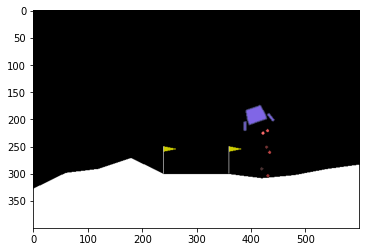

In [28]:
test()  # la animación no es tan fluida pero esta dentro de lo aceptable